<a href="https://colab.research.google.com/github/Simon-creator-jara/Inteligencia_artificial/blob/main/Fuzzy_Pt_1_definitivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio Fuzzy Potabilidad del agua

En este ejercicio de la clase de Razonamiento Aproximado, construiremos un modelo que a través de ciertas reglas lingüísticas de lógica difusa, pueda predecir el pH del agua según ciertas condiciones o datos existentes en una tabla de apoyo.

## 1. Librerías y descarga de la base.

In [ ]:
!pip install scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 993 kB 13.4 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=f98cdec6e5619702a56d13f22fc74fc6c5330f1b4e30ec3945f04eeb97052f8e
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


In [ ]:
#Importamos las librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import skfuzzy as fuzz
import pandas as pd
from random import seed
from random import random
plt.rcParams['figure.figsize']=(16,9)
plt.style.use('ggplot')

In [ ]:
df=pd.read_csv('water_potability.csv')

## 2. Revisión de los datos.

En primer lugar, es necesario entender el problema que se tiene, y por ello es necesario revisar la información que se tiene, y el fin al que se pretende llegar.

In [ ]:
df.sort_values(by='ph')

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3014,0.000000,214.846144,49456.587108,7.897539,NaN,583.448849,7.702328,77.712891,4.928840,0
726,0.227499,152.530111,39028.599340,3.462492,283.693782,443.029232,13.201943,62.322711,3.545741,1
2928,0.975578,221.204114,31145.110739,7.615583,333.677843,439.112765,21.145954,NaN,2.533996,0
810,0.989912,133.216942,16922.853899,9.293289,444.375731,322.291191,10.430076,43.578466,5.160604,1
2899,1.431782,228.130383,12937.246891,6.214773,319.734136,495.379883,12.033344,61.141119,4.948443,0
...,...,...,...,...,...,...,...,...,...,...
3224,NaN,198.218700,31081.735264,7.419106,NaN,517.925946,11.711419,85.428785,3.345543,1
3229,NaN,203.204659,10643.186771,6.828936,NaN,384.597711,16.011328,72.911573,3.065910,1
3231,NaN,225.754109,28194.452646,5.892830,366.201583,418.272901,17.306832,103.912548,3.855895,1
3245,NaN,188.536608,24711.414927,7.129520,NaN,555.548534,16.959269,56.038702,4.331691,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Tenemos en este caso, un DataFrame con 3276 datos tomados en fuentes hídricas diferentes; el DF en general tiene información referente a la dureza, la cantidad de sólidos, las cloraminas, sulfatos o carbon orgánico suspendido, pero además se encuentran otras propiedades tales como la turbidez del agua, la potabilidad o la conductividad eléctrica.

De todas estas columnas, la salida que queremos emular es la del pH, también conocido como potencial de hidrógeno, propiedad que habla de la acidez o la alcalinidad de un fluído, y se mide entre el 0 y el 14, siendo el número bajo una alta acidez, y el 14 la máxima alcalinidad posible...Teniendo todos estos datos en cuenta, lo que pretendemos hacer es poder predecir el pH del agua teniendo en cuenta las relaciones entre sus distintas propiedades (o al menos, las que sean realmente significativas).

In [ ]:
#Revisamos cuántos vacíos hay en este DataFrame; estos son datos que no nos sirven, o es mejor dejar de lado.
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [ ]:
#Borramos datos vacíos o datos NaN, para dejar la base lo más limpia que se pueda.
df=df.dropna()

Para garantizar la integridad y completitud de los datos, es sumamente importante hacer una limpieza de elementos vacíos, para dejar únicamente filas que tengan absolutamente todos sus entradas llenas; de otro modo lo que puede ocurrir es que el modelo tenga problemas al encontrar cecldas vacías que pueden ser un input importante para pdoer desarrollar el problema a nivel interno.

In [ ]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000
mean,7.085990,195.968072,21917.441374,7.134338,333.224672,426.526409,14.357709,66.400859,3.969729,0.403282
std,1.573337,32.635085,8642.239815,1.584820,41.205172,80.712572,3.324959,16.077109,0.780346,0.490678
min,0.227499,73.492234,320.942611,1.390871,129.000000,201.619737,2.200000,8.577013,1.450000,0.000000
25%,6.089723,176.744938,15615.665390,6.138895,307.632511,366.680307,12.124105,55.952664,3.442915,0.000000
50%,7.027297,197.191839,20933.512750,7.143907,332.232177,423.455906,14.322019,66.542198,3.968177,0.000000
75%,8.052969,216.441070,27182.587067,8.109726,359.330555,482.373169,16.683049,77.291925,4.514175,1.000000
max,14.000000,317.338124,56488.672413,13.127000,481.030642,753.342620,27.006707,124.000000,6.494749,1.000000


## 3. Identificación de variables relevantes.

Ahora bien; como pudimos observar en clase, los modelos difusos tienden a complicarse sobre manera cuando los mismos tienen demasiadas variables lingüísticas fuzzyficadas...Por esto, es necesario hacer una limpieza general del DataFrame y encontrar aquellas variables cuya correlación sea más fuerte con nuestra salida, que será justamente el pH.

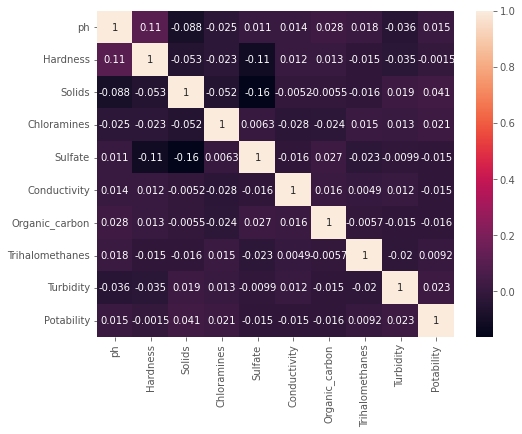

In [ ]:
corr_df = df.corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

Estos resultados en general, muestran que al menos para este set de datos, no existe una correlación fuerte entre el pH y alguna de las variables (por fuerte, nos referimos a mayor que 0.6) asociadas; sin embargo, es interesante observar hasta qué punto se puede llegar utilizando las variables con las que contamos, por lo que procedemos a escoger las 2 que más se relacionan con el resultado, siendo estas la dureza del agua y la cantidad de sólidos disueltos.

In [ ]:
dfc = df.loc[:,['ph','Hardness','Solids']]

In [ ]:
dfc.describe()

,ph,Hardness,Solids
count,2011.000000,2011.000000,2011.000000
mean,7.085990,195.968072,21917.441374
std,1.573337,32.635085,8642.239815
min,0.227499,73.492234,320.942611
25%,6.089723,176.744938,15615.665390
50%,7.027297,197.191839,20933.512750
75%,8.052969,216.441070,27182.587067
max,14.000000,317.338124,56488.672413


### Percentiles de dureza

Una de las variables que queremos revisar es la dureza; según la literatura, podemos definirla o enmarcarla en ciertos rangos que terminarían siendo los que se muestran a continuación.

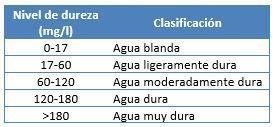

In [ ]:
percentile_dureza_1=stats.scoreatpercentile(dfc['Hardness'], 33)
percentile_dureza_2=stats.scoreatpercentile(dfc['Hardness'], 66)
print(f"Percentil 33: {percentile_dureza_1}")
print(f"Percentil 66: {percentile_dureza_2}")

Percentil 33: 183.90811894139398
Percentil 66: 208.3569464761424


Aunque bien podemos organizar la dureza en:

*   Agua Blanda: 0 -120
*   Agua Dura: 120 - 180
*   Agua Muy Dura: >180

Ya observamos que el percentil no va a coincidir con la totalidad de los datos, pues más del 60% de los mismos están solo en la parte de "muy duros", pero esta fuzzyficación únicamente sirve para tener una guía, y la distribución de la información no tiene nada qué ver.

### Percentiles de Sólidos

In [ ]:
percentile_solidos_1=stats.scoreatpercentile(dfc['Solids'], 33)
percentile_solidos_2=stats.scoreatpercentile(dfc['Solids'], 66)
print(f"Percentil 33: {percentile_solidos_1}")
print(f"Percentil 66: {percentile_solidos_2}")

Percentil 33: 17251.4673298651
Percentil 66: 24754.405137305846


In [ ]:
dfc.head()

,ph,Hardness,Solids
3,8.316766,214.373394,22018.417441
4,9.092223,181.101509,17978.986339
5,5.584087,188.313324,28748.687739
6,10.223862,248.071735,28749.716544
7,8.635849,203.361523,13672.091764


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7ed93a150>,
      dtype=object)

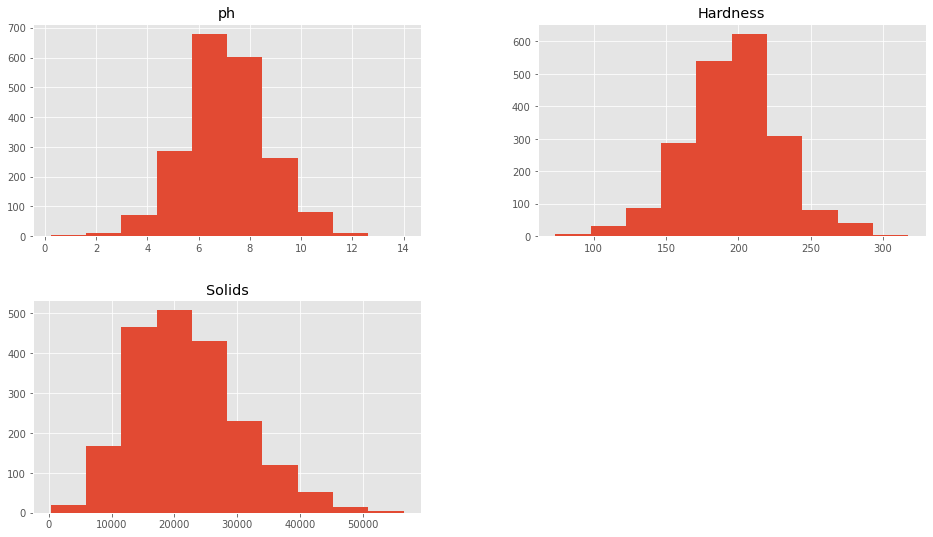

In [ ]:
dfc.hist()

Ahora, tras haber realizado el análisis de correlación, tenemos dos variables de entrada para fuzzyficar (la dureza y los sólidos) y una de salida con la que podemos contrastar la salida del modelo difuso, que es el pH o nivel de acidez del agua.

A partir de este punto pasamos a construír el problema desde los conceptos de vagueza, incertidumbre y error.

## 4. Fuzzyficación de las variables.

Ahora, vale la pena revisar el rango que utilizaremos para la variable de salida, que será el pH...Nuevamente se puede observar que el rango puede catalogarse en poco ácido, ácido, neutro, alcali y muy alcali; sin embargo, para normalizar y no aumentar exponencialmente la cantidad de salidas, solo se utilizarán 3 rangos, tal como se colocará a continuación.

Rango común del pH: 
- Ácido: 0 - 6
- Neutro = 6 - 8
- Base: 8 - 14 


Lo que haremos a continuacion será obtener los datos de mínimos y máximos para revisar si realmente existe una correlación entre la dureza y los sólidos suspendidos, y el grado de acidez del agua, pues de acá realmente saldrán las diferentes reglas del modelo.

In [ ]:
dfc.query("ph>=0 and ph<=6").describe()

,ph,Hardness,Solids
count,470.000000,470.000000,470.000000
mean,5.070414,190.219755,23126.844152
std,0.841578,34.536789,9078.348240
min,0.227499,100.806520,1351.906979
25%,4.739676,166.742257,16468.849443
50%,5.290336,189.457158,22082.227311
75%,5.671247,210.807423,28306.275652
max,5.999125,287.975540,55334.702799


In [ ]:
dfc.query("ph>6 and ph<=8").describe()

,ph,Hardness,Solids
count,1018.000000,1018.000000,1018.000000
mean,7.008552,196.900268,21846.893497
std,0.553595,29.024048,8192.801221
min,6.000723,97.280909,320.942611
25%,6.569565,179.088313,15938.858147
50%,6.978478,197.509503,21072.275412
75%,7.460332,214.957177,26734.723009
max,7.998090,306.627481,48175.852093


In [ ]:
dfc.query("ph>8 and ph<=14").describe()

,ph,Hardness,Solids
count,523.000000,523.000000,523.000000
mean,9.048041,199.319377,20967.916392
std,0.878453,36.680369,8974.537266
min,8.000776,73.492234,2552.962804
25%,8.353982,179.003150,14151.571604
50%,8.846282,201.651667,19946.264665
75%,9.528769,220.834041,26530.988090
max,14.000000,317.338124,56488.672413


En este punto realmente nos damos cuenta de que no existe una relación directa entre las variables y la salida, o de manera práctica, no necesariamente una dureza alta implica que el pH será alto (se puede observar además que lso rangos se incluyen mutuamente, significando entonces que en general, un pH puede tener cualquier cantidad de sólidos sumergidos, y puede ser lo dura o no que pueda, sin necesidad de que esto afecte trascendentalmente su pH...Las medias además son sumamente similares, y la única que parece tener una variación ligeramente considerable es la de cantidad de sólidos.

Este dato incluso pudimos haberlo deducido de la matriz de correlación, pues el tener una pearson menor de 15%, básicamente estamos afirmando que a relación entre la salida y esta entrada que revisamos, es básicamente tan débil que será complicado encontrar patrones particulares.

Ahora realizamos la graficación y fuzzyficación de la dureza y los sólidos...Para esta segunda variable en particular no existe un rango, por lo que utilizaremos los percentiles para establecer los dos rangos que se usarán en este caso, siendo ambos alto y bajo contenido de sólidos.

In [ ]:
#Dureza fuzzyficada
mf_qual = np.arange(0, 400, 1)
d_baja = fuzz.trapmf(mf_qual, [0, 10, 110,130])
d_media = fuzz.trapmf(mf_qual, [110, 120,180, 190])
d_alta = fuzz.trapmf(mf_qual, [170, 190, 385,395])

#Solidos fuzzyficados
mf_solid = np.arange(0, 60000, 1)
s_baja = fuzz.trapmf(mf_solid, [0, 100, 12000,18000])
s_alta = fuzz.trapmf(mf_solid, [16000, 20000, 45000,59000])

#pH Fuzzyficado
mf_ph = np.arange(0, 15, 1)
ph_acid = fuzz.trapmf(mf_ph, [0, 1, 5, 7])
ph_neutral = fuzz.trimf(mf_ph, [6, 7, 8])
ph_basic = fuzz.trapmf(mf_ph, [7, 9, 13, 14])

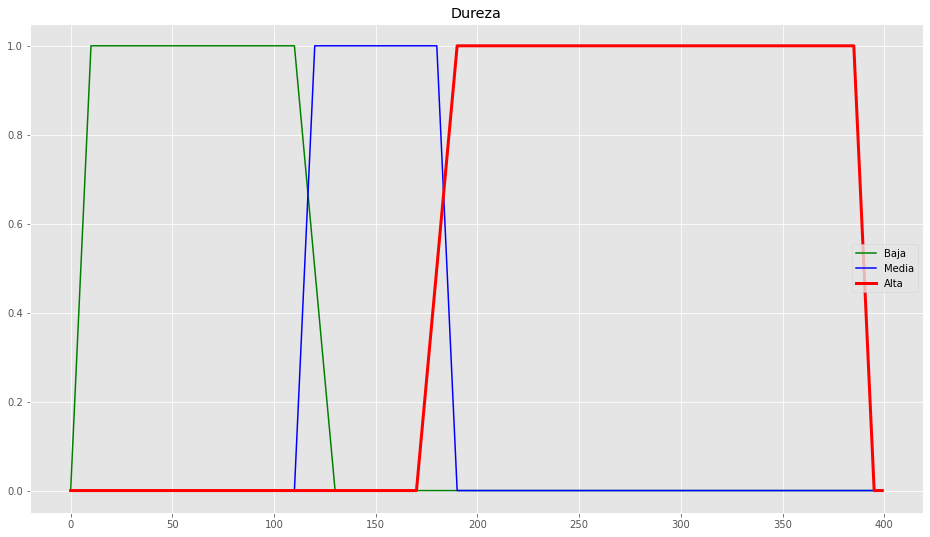

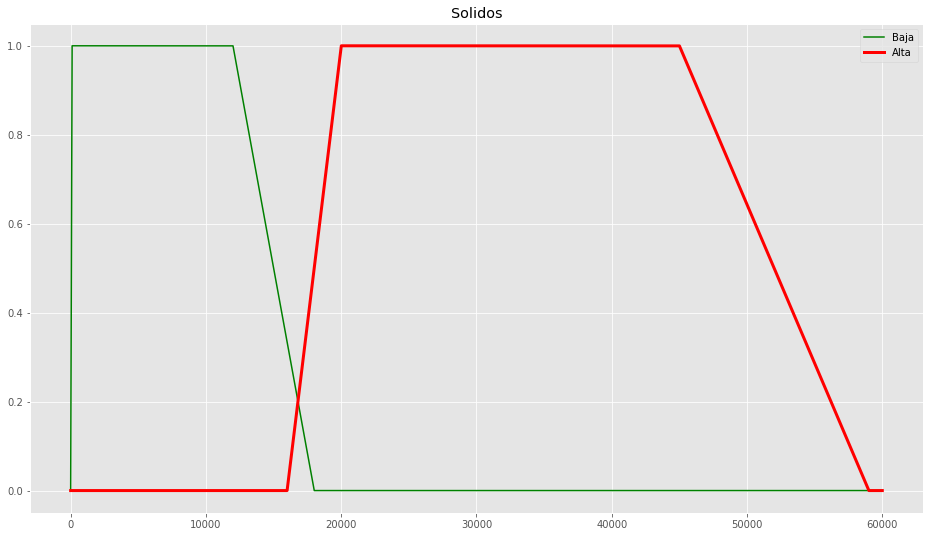

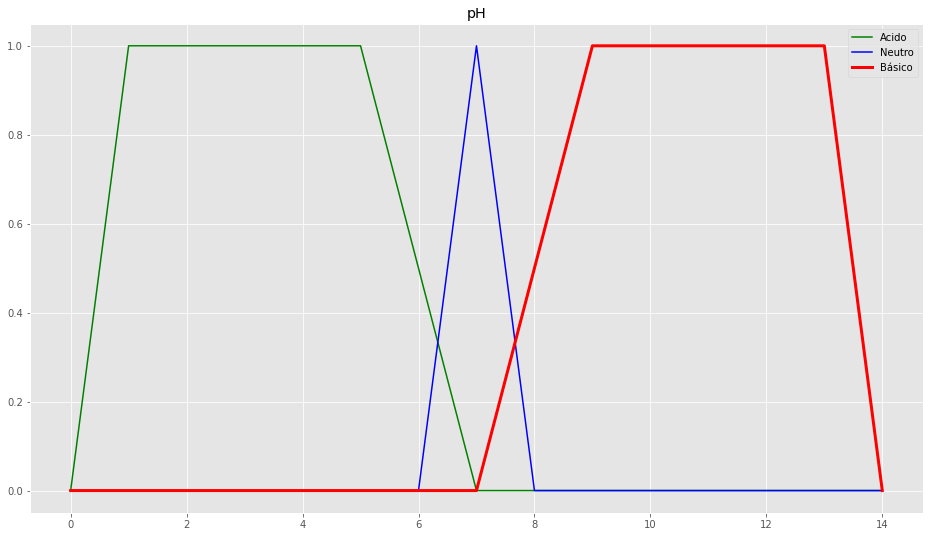

In [ ]:
# To see how these look with plot
plt.plot(mf_qual, d_baja, 'g', linewidth=1.5, label='Baja')
plt.plot(mf_qual, d_media, 'b', linewidth=1.5, label='Media')
plt.plot(mf_qual, d_alta, 'r', linewidth=3, label='Alta')

plt.title('Dureza')
plt.legend()
plt.show()

# To see how these look with plot
plt.plot(mf_solid, s_baja, 'g', linewidth=1.5, label='Baja')
plt.plot(mf_solid, s_alta, 'r', linewidth=3, label='Alta')

plt.title('Solidos')
plt.legend()
plt.show()

# To see how these look with plot
plt.plot(mf_ph, ph_acid, 'g', linewidth=1.5, label='Acido')
plt.plot(mf_ph, ph_neutral, 'b', linewidth=1.5, label='Neutro')
plt.plot(mf_ph, ph_basic, 'r', linewidth=3, label='Básico')

plt.title('pH')
plt.legend()
plt.show()

Fuzzyficamos y vectorizamos las variables de dureza (en 3 trozos) y la de sólidos (en 2).

In [ ]:
def Fuzzfydureza(qualVal):
  fzz_qual = np.zeros(3)
  fzz_qual[0] = fuzz.interp_membership(mf_qual, d_baja, qualVal)
  fzz_qual[1] = fuzz.interp_membership(mf_qual, d_media, qualVal)
  fzz_qual[2] = fuzz.interp_membership(mf_qual, d_alta, qualVal)
  return fzz_qual

#----------------------------------
def FuzzfySolids(svcVal):
  fzz_svc = np.zeros(3)
  fzz_svc[0] = fuzz.interp_membership(mf_solid, s_baja, svcVal)
  fzz_svc[1] = fuzz.interp_membership(mf_solid, s_alta, svcVal)
  return fzz_svc

## 5. Evaluación de reglas.

In [ ]:
def evalRules(fuzzedQal, fuzzedSvc):
  outVarS = np.zeros(3)
  outVarS[0] = max(outVarS[0], max(min(fuzzedQal[0], fuzzedSvc[1]),min(fuzzedQal[2], fuzzedSvc[1]))) # rule1 si dureza alta y solidos bajos es acido
  outVarS[1] = max(outVarS[1], max(min(fuzzedQal[1], fuzzedSvc[0]),min(fuzzedQal[1], fuzzedSvc[1]))) # rule2 si ambas medias eso es neutro
  outVarS[2] = max(outVarS[2], max(min(fuzzedQal[2], fuzzedSvc[0]),min(fuzzedQal[0], fuzzedSvc[0]))) # rule3 si dureza baja y solidos altos es base
  return outVarS

def setOutMFs(outRuleVars):

  t_low_max = np.full(np.shape(mf_ph),outRuleVars[0])
  t_ave_max = np.full(np.shape(mf_ph),outRuleVars[1])
  t_hig_max = np.full(np.shape(mf_ph),outRuleVars[2])

  # copy the MF from the original clipped by the level from above.
  t_out_low = np.fmin(t_low_max, ph_acid)
  t_out_ave = np.fmin(t_ave_max, ph_neutral)
  t_out_hig = np.fmin(t_hig_max, ph_basic)
  

  # Retorno de una sola variable.
  t_Out_mfs = np.stack((t_out_low, t_out_ave, t_out_hig))

  return t_Out_mfs

In [ ]:
def execFzzedRules(scroeQual, scoreSvc):

  # Fuzzyficar los scores.
  fzzedQal = Fuzzfydureza(scroeQual)
  fzzedSvc = FuzzfySolids(scoreSvc)


  # Evaluar las reglas y obtener la calidad.
  EvaledRs = evalRules(fzzedQal, fzzedSvc)
  #print( EvaledRs)
  outMFs = setOutMFs(EvaledRs)

  # Una sola defuzzyficación.
  outTempMF =  fuzz.fuzzy_or(mf_ph, outMFs[0], mf_ph, outMFs[1])
  outTotalMF =  fuzz.fuzzy_or(mf_ph, outTempMF[1], mf_ph, outMFs[2])
  print(outTotalMF)

  # Obtener el output.
  fTip = fuzz.defuzz(outTotalMF[0], outTotalMF[1],'centroid')

  # plt.plot(outTotalMF[0], outTotalMF[1], 'r', linewidth=3, label='Final aggregated MFs')
  # plt.plot([fTip,fTip], [0, 1], 'g', linewidth=1.5, label='Defuzz Result')
  # plt.title('Aggregated MFs')
  # plt.legend()
  # plt.show()



  return (fTip)

In [ ]:
df.reset_index(drop=True,inplace=True)

In [ ]:
lista=[]
label=[]
label_pred=[]
for i in range(len(df)):
  lista.append(execFzzedRules(df['Hardness'][i],df['Solids'][i]))
  if int(df['ph'][i])>=0 and  int(df['ph'][i])<7:
    label.append('Acido')
  elif int(df['ph'][i])>=7 and  int(df['ph'][i])<8:
    label.append('Neutro')
  elif int(df['ph'][i])>7:
    label.append('Base')
  if int(execFzzedRules(df['Hardness'][i],df['Solids'][i]))>=0 and  int(execFzzedRules(df['Hardness'][i],df['Solids'][i]))<7:
    label_pred.append('Acido')
  elif int(execFzzedRules(df['Hardness'][i],df['Solids'][i]))>=7 and  int(execFzzedRules(df['Hardness'][i],df['Solids'][i]))<8:
    label_pred.append('Neutro')
  elif int(execFzzedRules(df['Hardness'][i],df['Solids'][i]))>7:
    label_pred.append('Base')
  




df['Prediccion']=pd.DataFrame(lista,index=df.index)
df['Label']=pd.DataFrame(label,index=df.index)
df['Label_Pred']=pd.DataFrame(label_pred,index=df.index)

In [ ]:
from sklearn.metrics import classification_report


print(classification_report(df['Label'], df['Label_Pred'], target_names=['Acido','Neutro','Base']))

              precision    recall  f1-score   support

       Acido       0.48      0.57      0.52       992
      Neutro       0.32      0.30      0.31       523
        Base       0.15      0.11      0.13       496

    accuracy                           0.39      2011
   macro avg       0.32      0.33      0.32      2011
weighted avg       0.36      0.39      0.37      2011

